## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
gray = []
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Calibrate the camera

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (gray.shape[::-1]), None, None)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def undistort(img):    
    undist =  cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## check calibration result

In [ ]:
undist = []
plt.figure(1, figsize=(50,50))
i = 0

for fname in images:
    img = cv2.imread(fname)
    undist = undistort(img)
    #plt.subplot(len(images), 1 , i+1)
    #plt.imshow(undist)
    i = i +1 
    undist_file_name = "camera_cal/"+"undistort"+str(i)+".jpg"
    origin_file_name = "camera_cal/"+"origin"+str(i)+".jpg"

    cv2.imwrite(undist_file_name,undist)
    cv2.imwrite(origin_file_name,img)

In [ ]:
import pickle
pickle.dump( (ret, mtx, dist, rvecs, tvecs), open( "calib.p", "wb" ) )


 ### Here I can use the calibration for further processing

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
(ret, mtx, dist, rvecs, tvecs) = pickle.load( open( "calib.p", "rb" ))

In [3]:
def undistort_img(img, mtx, dist):    
    undist =  cv2.undistort(img, mtx, dist, None, mtx)
    return undist 

In [4]:
# parameters
s_thresh=(170, 255)
sx_thresh=(20, 100)

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    binary = np.zeros_like(s_channel)
    binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary

def binarize_img(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(30, 100))
    #grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(30, 100))
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(100, 200))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.8, 1.2))
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Threshold color channel
    s_channel = hls_select(img, thresh=(150, 255))
     # Stack each channel
      
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_channel == 1) | (combined == 1)] = 1
    
    return combined_binary
        

In [19]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)): 
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
     # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

In [ ]:


# test 
plt.figure(1, figsize=(100,40))
ksize = 3
test_images = glob.glob('test_images/*.jpg')
test_imgs = []
for fname in test_images:
    img = cv2.imread(fname)
    test_imgs.append(img)
    
    
#img = test_imgs[6]
img = cv2.imread('test_images/test5.jpg')
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) ,cmap='brg')

gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(30, 150))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(30, 100))
mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(100, 200))
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.8, 1.2))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) ) | ((mag_binary == 1) & (dir_binary == 1))] = 1
s_channel = hls_select(img, thresh=(140, 255))

result = binarize_img (img)

xy = np.zeros_like(dir_binary)
xy[((gradx == 1))]   = 1
mag_dir = np.zeros_like(dir_binary)
mag_dir[((mag_binary == 1) & (dir_binary == 1))] = 1
binary = np.zeros_like(dir_binary)
binary[(s_channel == 1) | (combined == 1)] = 1
# original
plt.subplot(5, 1 ,1)
plt.imshow(binary,cmap='gray')
plt.title('binary')

# vertical

plt.subplot(5, 1, 2)
plt.imshow(xy,cmap='gray')
plt.title('xy')
# horizontal
plt.subplot(5, 1, 3)
plt.imshow(combined,cmap='gray')
plt.title('combined without s channel')

# magnitude
plt.subplot(5, 1, 4)
plt.imshow(s_channel,cmap='gray')
plt.title('s channel')

# magnitude
#plt.subplot(5, 1, 5)
#plt.imshow(dir_binary,cmap='gray')


In [ ]:
## test pipeline
plt.figure(1, figsize=(50,100))

test_images = glob.glob('test_images/test5.jpg')

i = 0
for fname in test_images:
    img = cv2.imread(fname)
    (color_binary,sxbinary,s_binary, combined_binary) = binarize_img(img)
    
    plt.subplot(len(test_images), 4 , i * 4  +1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) ,cmap='brg')
    
    plt.subplot(len(test_images), 4 , i * 4  +2)binarize_img
    plt.imshow(sxbinary,cmap='gray')

    plt.subplot(len(test_images), 4 , i * 4 + 3)
    plt.imshow(s_binary,cmap='gray' )
    
    plt.subplot(len(test_images), 4 , i * 4 + 4)
    plt.imshow(combined_binary,cmap='gray' )
    
    i = i + 1
    

### Perspective Transformation 

In [ ]:
plt.figure(1, figsize=(10,10))

straight_line = cv2.imread('test_images/straight_lines2.jpg')
straight_line_rgb = cv2.cvtColor(straight_line, cv2.COLOR_BGR2RGB)

# undistort 
straight_line_rgb_undistort = undistort_img(straight_line_rgb, mtx, dist)    
# 
pt1 = (315 , 650  )
pt2 = (608 , 440  )
pt3 = (673,  440)
pt4 = (1000, 650)
cv2.line(straight_line_rgb_undistort, pt1, pt2, (255,0,0), thickness=1 ) 
cv2.line(straight_line_rgb_undistort, pt2, pt3, (255,0,0), thickness=1 ) 
cv2.line(straight_line_rgb_undistort, pt3, pt4, (255,0,0), thickness=1 ) 

plt.imshow(straight_line_rgb_undistort )


In [ ]:
image_shape = straight_line_rgb.shape
image_shape[0:2]

In [ ]:
pt2_dist = (pt1[0] , -440  )
pt3_dist = (pt4[0] , -440  )
src = np.float32([pt1,pt2,pt3,pt4]) 
dst = np.float32([pt1,pt2_dist,pt3_dist,pt4])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(straight_line_rgb_undistort, M , (1280,720))
plt.imshow(warped )
pickle.dump( M, open( "warp_perspective.p", "wb" ) )


In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# parameters
image_shape_g =  (1280,720)
M_g = pickle.load( open( "warp_perspective.p", "rb" ))


In [7]:
def perspective_transform(img):
    return cv2.warpPerspective(img, M_g , image_shape_g)


In [8]:
def pipeline(img):
    # undistort
    undistort = undistort_img(img, mtx, dist)
    # binarize
    (combined_binary) = binarize_img(undistort)
    # perspective transform
    img_perspective = perspective_transform(combined_binary)
    
    return (img_perspective, undistort , combined_binary)

In [ ]:
plt.figure(1, figsize=(20,40))

i = 0
nr_col = 4
for fname in test_images:
    img = cv2.imread(fname)
    
    #undistort = undistort_img(img, mtx, dist)
    # binarize
    #(combined_binary) = binarize_img(undistort)
    
    (img_pers ,undistort,  combined_binary)  = pipeline(img)
    
    
    
    plt.subplot(len(test_images), nr_col , i * nr_col  +1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) ,cmap='brg')
    
    plt.subplot(len(test_images), nr_col , i * nr_col  +2)
    plt.imshow(combined_binary,cmap='gray')
    
    plt.subplot(len(test_images), nr_col , i * nr_col  +3)
    plt.imshow(img_pers,cmap='gray')
    
    (out_img, ploty, left_fitx, right_fitx) = find_lane(img_pers)

    plt.subplot(len(test_images), nr_col , i * nr_col + 4)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.imshow(out_img )lefty

    
 
    i = i + 1


In [ ]:
import numpy as np

plt.figure(1, figsize=(40,40))


img = cv2.imread('test_images/test5.jpg')

(img_perspective, undistort , combined_binary) = pipeline(img)
#histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.subplot(3,1,1)
#plt.plot(histogram)
plt.imshow(img_perspective , cmap='gray')lefty
plt.subplot(3, 1 , 2 )
histogram = np.sum(img_perspective[img_perspective.shape[0]//2:,:], axis=0)
plt.plot(histogram )
plt.subplot(3,1,3)
plt.imshow(combined_binary , cmap='gray')


In [39]:
import copy
def find_lane( image_warped ):
    binary_warped = copy.copy(image_warped)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    out_img = out_img.astype( np.uint8)
    # Find the peak of the left and right halves of the histogram
    # plt.imshow(binary_warped , cmap='gray')
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # print (midpoint, leftx_base, rightx_base)

    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #print ('None zero y ', nonzeroy)
    #print ('None zero x ', nonzerox)
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    length_lane_pixel = 750 # this parameter is updated dynamically

    # Step through the windows one by one
    window_nr = 0
    for window in range(nwindows):

        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image 
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        #print  ( len(good_left_inds) , len(good_right_inds) )
        # print (good_left_inds)
        
        # Append these indices to the lists
        if len(good_left_inds) > minpix:           
            left_lane_inds.append(good_left_inds)
        else:
            if len(good_right_inds) > minpix and window_nr > 1 :
                # append new non zero index 
                rightx_offset = nonzerox[good_right_inds] - length_lane_pixel
                righty_offset = nonzeroy[good_right_inds] 
                left_lane_inds.append(list(range( nonzeroy.shape[0], nonzeroy.shape[0]+ righty_offset.shape[0])) )
                nonzeroy = np.append(nonzeroy , righty_offset)
                nonzerox = np.append(nonzerox , rightx_offset)
                    
            
        if len(good_right_inds) > minpix:           
            right_lane_inds.append(good_right_inds)
        else:
            if len(good_left_inds) > minpix and window_nr > 1:
                leftx_offset = nonzerox[good_left_inds] +  length_lane_pixel
                lefty_offset = nonzeroy[good_left_inds] 
                right_lane_inds.append(list(range( nonzeroy.shape[0], nonzeroy.shape[0] + lefty_offset.shape[0])))
                nonzeroy = np.append(nonzeroy , lefty_offset)
                nonzerox = np.append(nonzerox , leftx_offset)
                
            
        # If you found > minpix pixels, recenter next window on their mean position
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        if  len(good_left_inds) > minpix and len(good_right_inds) > minpix:
            length_lane_pixel =  rightx_current - leftx_current
            # print ('dynamic lane pixel', length_lane_pixel)
        
        window_nr = window_nr + 1
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return (out_img, ploty, left_fitx, right_fitx,  left_fit, right_fit)

#plt.imshow(out_img)
#plt.plot(left_fitx, ploty, color='yellow')
#plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

### TEST IMAGE

In [ ]:
img = cv2.imread('test_images/test1.jpg')
plt.figure(1, figsize=(10,16))
plt.subplot(4,1,1)
plt.imshow( cv2.cvtColor(img, cv2.COLOR_BGR2RGB) ,cmap='brg'  )

In [ ]:
image = cv2.imread('test_images/test5.jpg')
plt.figure(1, figsize=(10,16))
plt.subplot(4,1,1)
img = np.copy(image)
(img_perspective, undistort , combined_binary) = pipeline(img)
#histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
(out_img, ploty, left_fitx, right_fitx,  left_fit, right_fit) = find_lane(img_perspective)
plt.imshow( cv2.cvtColor(image, cv2.COLOR_BGR2RGB) ,cmap='brg'  )

plt.subplot(4,1,2)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img )

plt.subplot(4,1,3)
#ploty, left_fitx, right_fitx, left_fit, right_fit) = track_lane_line(img_perspective, left_fit, right_fit )
#isualize_tracking(img_perspective, ploty, left_fitx, right_fitx )
 

In [10]:
def compute_curvature (leftx, lefty, rightx, righty):
    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)   
    ym_per_pix = 30/720 # meters per pixel in y dimension 
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return (left_curverad,  right_curverad)


In [11]:
def track_lane_line(image_perpective, left_fit, right_fit ):
    binary_warped = copy.copy(image_perpective)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # compute curvature and determine if tracking is lost 
    (curvature_left, curvature_right ) = compute_curvature (leftx, lefty, rightx, righty)
    print ('curvature ',curvature_left , curvature_right)
    print ('radius difference ', np.fabs(curvature_left - curvature_right))
    tracking_lost = False
    if np.fabs(curvature_left - curvature_right) > 200:
        tracking_lost = True
    return (ploty, left_fitx, right_fitx, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy , tracking_lost)

In [ ]:
(ploty, left_fitx, right_fitx, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox,nonzeroy) = track_lane_line(img_perspective, left_fit, right_fit )
visualize_tracking(img_perspective, ploty, left_fitx, right_fitx , left_lane_inds, right_lane_inds, nonzerox, nonzeroy, 100 )

In [12]:
def visualize_tracking(binary_warped, ploty, left_fitx, right_fitx ,left_lane_inds, right_lane_inds, nonzerox,nonzeroy, margin ):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype( np.uint8)
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)


In [13]:
def inverse_warp(undist,   left_fitx , right_fitx, ploty , Minv):
    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(undist).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = np.zeros_like(undist).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
# plt.imshow(result)

In [ ]:
result = inverse_warp( undistort , left_fitx , right_fitx, ploty,  np.linalg.inv(M_g) )
plt.imshow( cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



100%|█████████▉| 1260/1261 [09:19<00:00,  2.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 16min 30s, sys: 4min 20s, total: 20min 50s
Wall time: 9min 21s


In [40]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    (img_pers ,undistort,  combined_binary)  = pipeline(image_rgb)
    (out_img, ploty, left_fitx, right_fitx,  left_fit, right_fit) = find_lane(img_pers)
    output = inverse_warp( undistort , left_fitx , right_fitx, ploty,  np.linalg.inv(M_g) )
    return cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

In [ ]:
i = 0
ploty = None
left_fitx = None
right_fitx = None
left_fit = None 
right_fit = None 
tracking_lost = True 
frame_begin = 500
frame_end = 620

for frame in clip1.iter_frames():
    print ('process frame ', i)
    if (i > frame_begin and i < frame_end ):
        image = np.asarray(frame)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        (img_pers ,undistort,  combined_binary)  = pipeline(image_rgb)
        #if i == 0 or tracking_lost is True:
        (out_img, ploty, left_fitx, right_fitx,  left_fit, right_fit) = find_lane(img_pers)
        #    tracking_lost = True
        #else :
        #    (ploty, left_fitx, right_fitx, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox,nonzeroy, tracking_lost)  =  track_lane_line(img_pers, left_fit, right_fit )
        #    if (tracking_lost is True):
        #        (out_img, ploty, left_fitx, right_fitx,  left_fit, right_fit) = find_lane(img_pers)
        #        tracking_lost = False
        output = inverse_warp( undistort , left_fitx , right_fitx, ploty,  np.linalg.inv(M_g) )
        file_name = 'output'+str(i) + '.jpg' 
        debug_name = 'debug'+str(i) + '.jpg' 
        cv2.imwrite(debug_name, out_img)
        cv2.imwrite(file_name, output)
    i = i + 1
    

### Debug on some tricky images

In [ ]:
type(clip1.iter_frames())

In [29]:
i = 0
for frame in clip1.iter_frames():
    if i == 560 or i == 595 or i== 1037 or i == 551 :
        image = np.asarray(frame)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        file_name = 'tricky'+str(i) + '.jpg' 
        cv2.imwrite(file_name, image_rgb)
    i +=1
    # (img_pers ,undistort,  combined_binary)  = pipeline(frame)

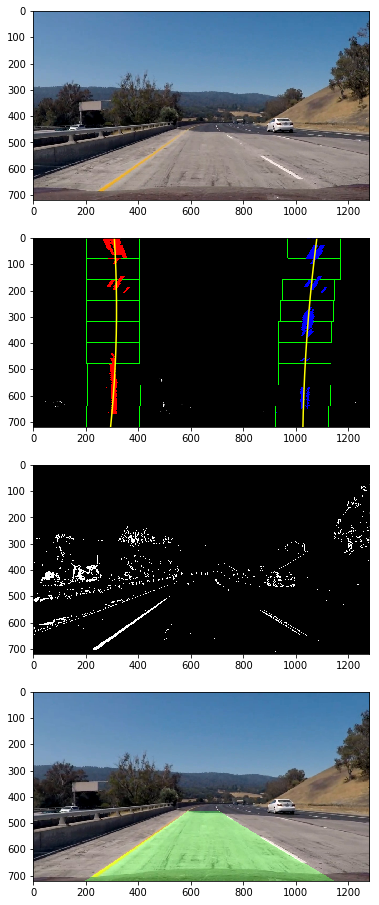

In [30]:
image_t = cv2.imread('tricky595.jpg')
plt.figure(1, figsize=(10,16))
plt.subplot(4,1,1)
img_t = np.copy(image_t)
(img_perspective_t, undistort_t , combined_binary_t) = pipeline(img_t)
(out_img_t, ploty_t, left_fitx_t, right_fitx_t,  left_fit_t, right_fit_t) = find_lane(img_perspective_t)
output_t = inverse_warp( undistort_t , left_fitx_t , right_fitx_t, ploty_t,  np.linalg.inv(M_g) )

plt.imshow(  cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB)  ,cmap='brg'  )
    

plt.subplot(4,1,2)
plt.plot(left_fitx_t, ploty_t, color='yellow')
plt.plot(right_fitx_t, ploty_t, color='yellow')
plt.imshow(out_img_t )

plt.subplot(4,1,3)
plt.imshow(combined_binary_t, cmap='gray' )

plt.subplot(4,1,4)
plt.imshow(cv2.cvtColor(output_t, cv2.COLOR_BGR2RGB), cmap='brg' )

